Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
import seaborn as sns

Downloading data by http request

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'

Transfer in pandas

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,...,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2017-18,2018-01,2018-05,146,European Voluntary Service - Programme Countries,???,PT,??? - ???,Male,...,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2017-18,2018-01,2018-05,146,European Voluntary Service - Programme Countries,???,PT,??? - ???,Male,...,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,...,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,...,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,...,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688505,2018-2-UK01-KA125-048625,2018-19,2018-09,2019-07,319,Individual Volunteering Activities,???,ES,??? - ???,Female,...,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
688506,2018-2-UK01-KA125-048626,2018-19,2018-10,2019-03,137,Individual Volunteering Activities,???,ES,??? - ???,Male,...,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
688507,2018-2-UK01-KA125-048626,2018-19,2018-11,2019-04,170,Individual Volunteering Activities,???,CZ,??? - ???,Female,...,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
688508,2018-2-UK01-KA125-048626,2018-19,2018-11,2019-10,351,Individual Volunteering Activities,???,FR,??? - ???,Male,...,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


## Mobility network
Simply focused on the number of the excange

In [4]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20))]]
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
mobility_df

,Sending Organization,Receiving Organization,Participants,SendId,RecId
0,ADAMASTOR - ASSOCIACAO CULTURAL,Stowarzyszenie Jeden Swiat,1,36196,74530
1,ADAMASTOR - ASSOCIACAO CULTURAL,Stowarzyszenie Jeden Swiat,1,36196,74530
53,Landesberufsschule Arnfels,Language Xchange Ireland,1,22344,62655
54,Landesberufsschule Arnfels,Language Xchange Ireland,1,22344,62655
55,Landesberufsschule Arnfels,Language Xchange Ireland,1,22344,62655
...,...,...,...,...,...
688505,Asociación para la integración y Progreso de l...,The National Trust for Places of Historic Inte...,1,94867,77610
688506,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,VOLUNTEER ACTION FOR PEACE,1,43551,81486
688507,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,VOLUNTEER ACTION FOR PEACE,1,37314,81486
688508,SOLIDARITES JEUNESSES MCP,VOLUNTEER ACTION FOR PEACE,1,30263,81486


In [5]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

In [6]:
adj_matrix_crs, mobility_df, nodes_df= ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

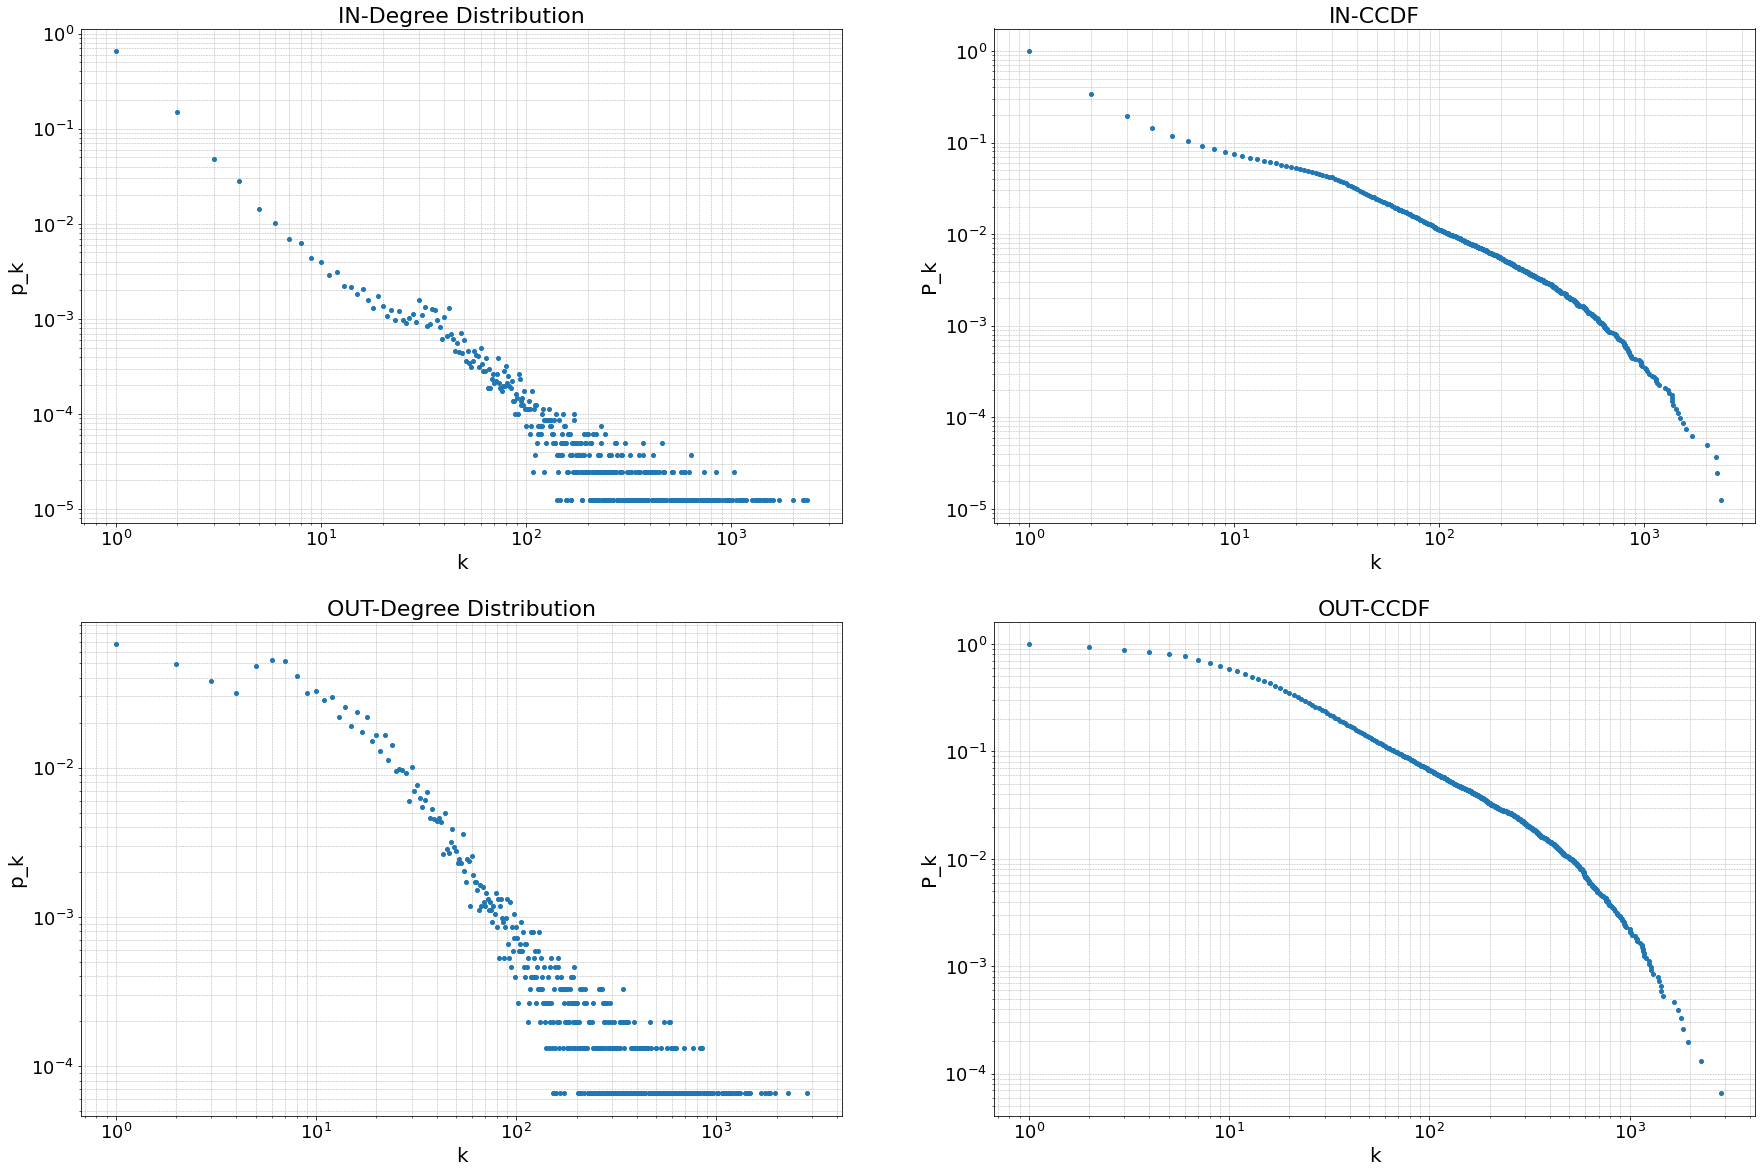

Top 10 for in degree


,Nodes,in degree
25240,UNIVERSITAT DE VALENCIA,2352
85235,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2264
78133,UNIVERSIDADE DE LISBOA,2248
23510,UNIVERSIDAD DE GRANADA,2011
6045,UNIVERSIDAD COMPLUTENSE DE MADRID,1707
32004,UNIVERZA V LJUBLJANI,1593
54893,UNIVERSITAT POLITECNICA DE VALENCIA,1548
32671,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1495
58229,KATHOLIEKE UNIVERSITEIT LEUVEN,1465
59053,UNIVERSIDAD DE SEVILLA,1427


Top 10 for out degree


,Nodes,out degree
85235,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2845
23510,UNIVERSIDAD DE GRANADA,2282
21924,UNIVERSITA DEGLI STUDI DI PADOVA,1966
27712,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1842
6045,UNIVERSIDAD COMPLUTENSE DE MADRID,1815
25240,UNIVERSITAT DE VALENCIA,1753
8557,UNIVERSITA DEGLI STUDI DI TORINO,1673
32004,UNIVERZA V LJUBLJANI,1469
78133,UNIVERSIDADE DE LISBOA,1443
51664,Association Ouvrière des Compagnons du Devoir ...,1437


In [7]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

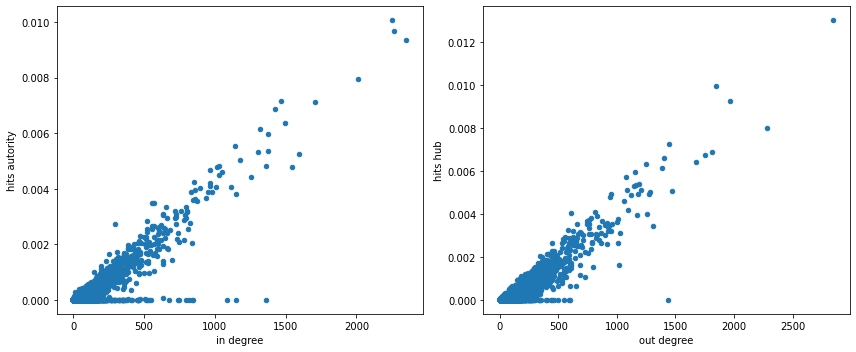

Top 10 for hits hub


,Nodes,hits hub
85235,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.012997
27712,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.009939
21924,UNIVERSITA DEGLI STUDI DI PADOVA,0.009242
23510,UNIVERSIDAD DE GRANADA,0.007984
78133,UNIVERSIDADE DE LISBOA,0.007260
6045,UNIVERSIDAD COMPLUTENSE DE MADRID,0.006882
25240,UNIVERSITAT DE VALENCIA,0.006745
58229,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006614
8557,UNIVERSITA DEGLI STUDI DI TORINO,0.006424
61840,TECHNISCHE UNIVERSITAET MUENCHEN,0.006332


Top 10 for hits autority


,Nodes,hits autority
78133,UNIVERSIDADE DE LISBOA,0.010064
85235,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.009687
25240,UNIVERSITAT DE VALENCIA,0.009342
23510,UNIVERSIDAD DE GRANADA,0.007957
58229,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007145
6045,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007113
59053,UNIVERSIDAD DE SEVILLA,0.006877
32671,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.006364
75410,UNIVERSITAT DE BARCELONA,0.006159
24515,UNIVERZITA KARLOVA,0.005982


In [8]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

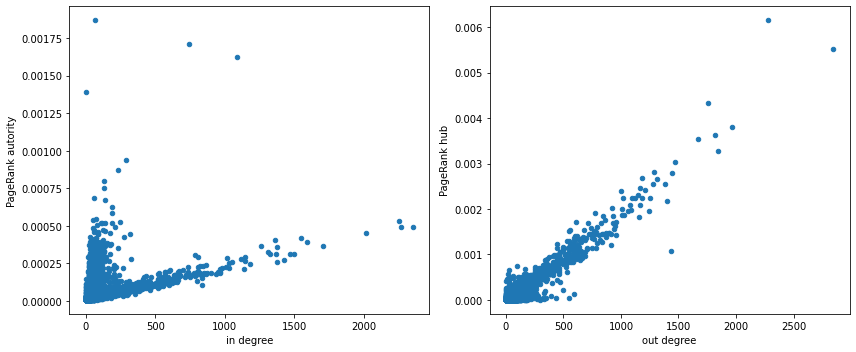

Top 10 for PageRank hub


,Nodes,PageRank hub
23510,UNIVERSIDAD DE GRANADA,0.006148
85235,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.005523
25240,UNIVERSITAT DE VALENCIA,0.004324
21924,UNIVERSITA DEGLI STUDI DI PADOVA,0.003799
6045,UNIVERSIDAD COMPLUTENSE DE MADRID,0.003628
8557,UNIVERSITA DEGLI STUDI DI TORINO,0.003534
27712,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.003281
32004,UNIVERZA V LJUBLJANI,0.003043
50319,UNIVERSIDAD POLITECNICA DE MADRID,0.002820
78133,UNIVERSIDADE DE LISBOA,0.002789


Top 10 for PageRank autority


,Nodes,PageRank autority
82367,"SDRUJENIE "" FC PALDIN"" PLOVDIV",0.001868
38862,FUNDACJA KRZYZOWA DLA POROZUMIENIA EUROPEJSKIEGO,0.001709
7421,ADC Technology Training Ltd,0.001626
48780,Hogbergsskolan,0.001390
29309,STICHTING DE OLDE VECHTE,0.000941
88420,Europahaus Marienberg,0.000871
31168,DHKEXE DHMOTIKH EPIXEIRHSH DHMOY XYLOKASTROY-E...,0.000799
15389,ASSOCIAZIONE ARTEMIDE,0.000752
64482,Rezeknes pilsetas Nacionalo biedribu kulturas ...,0.000683
48415,Bildungsnetzwerk Magdeburg gGmbH,0.000670


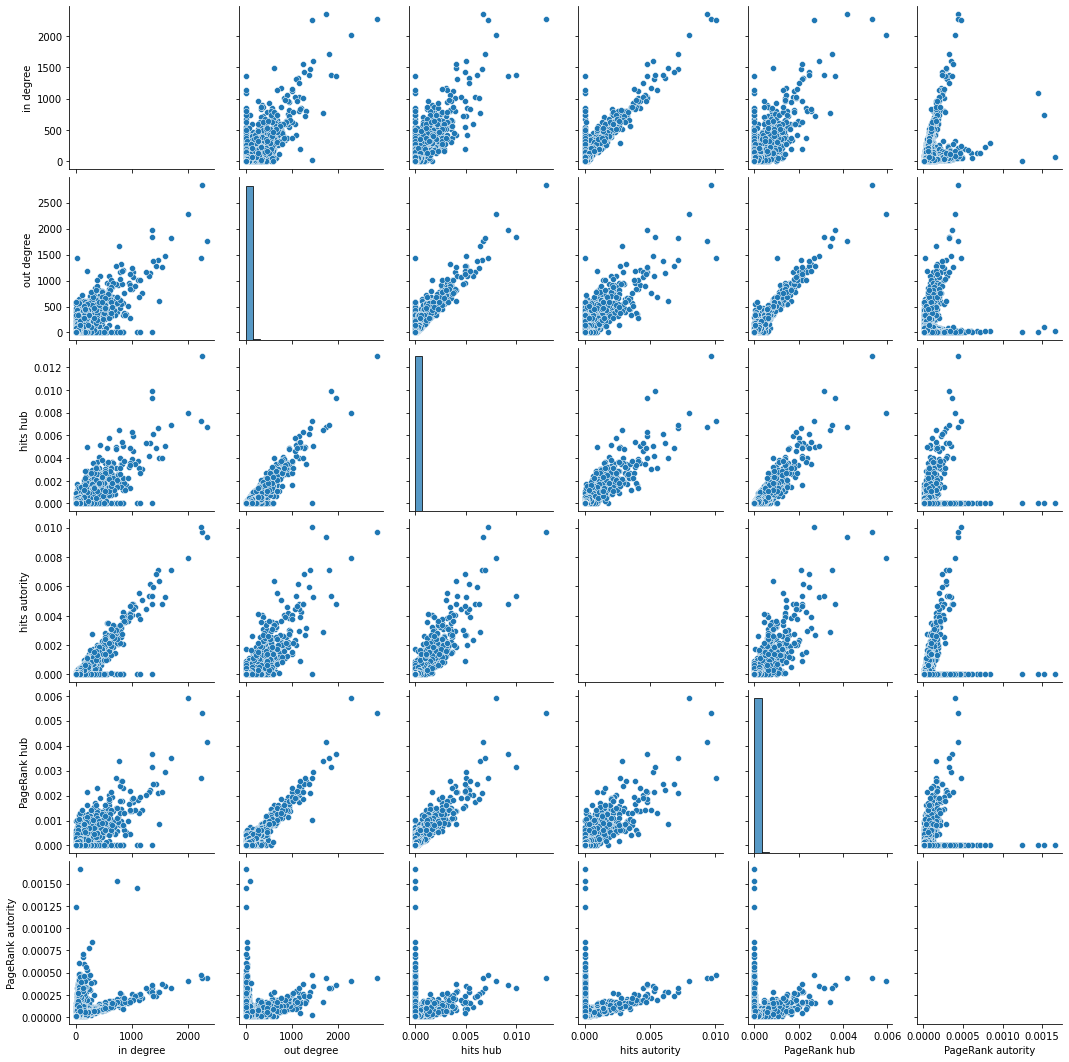

In [9]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
# sns.pairplot(scores)
# plt.show()
from IPython.display import Image
Image('pairplot_score.png',)

### Assortativity

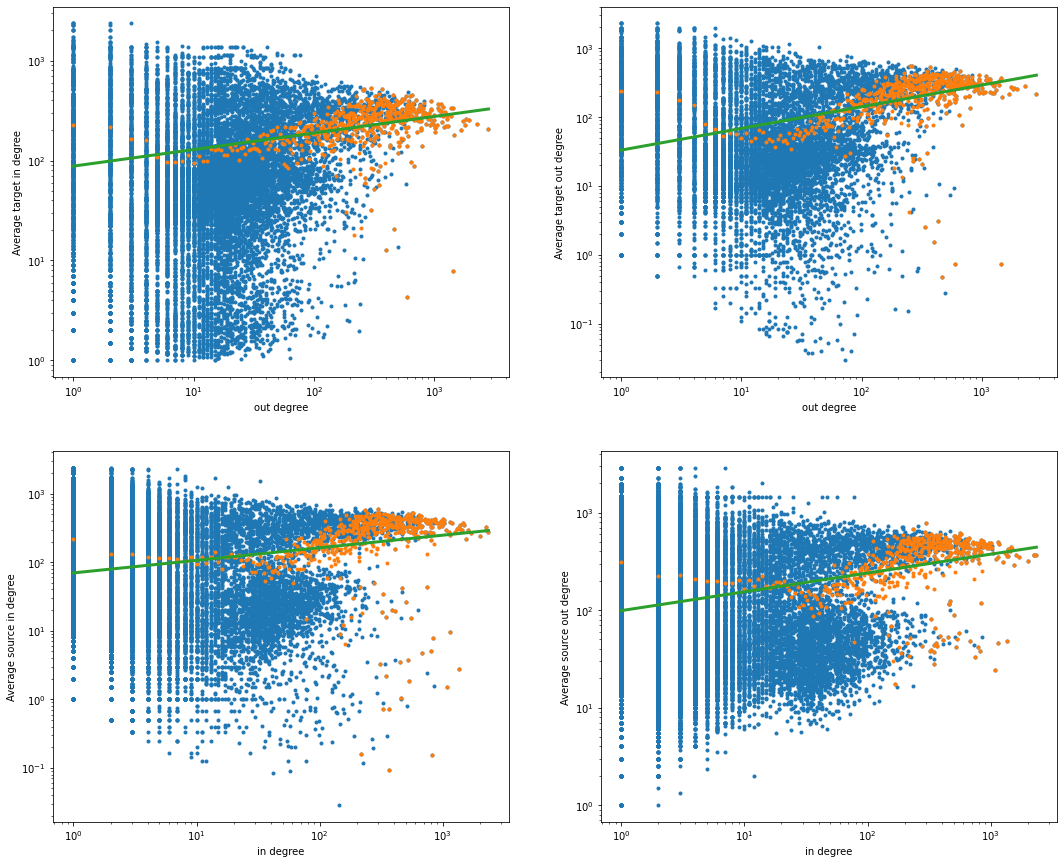

(0.1654258796478265,
 0.31454576243319515,
 0.18334316171200302,
 0.19271936954374286)

In [10]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)